# Framework

- Data - Palbociclib Data (Proteomics and GDSC2)
- Preprocessing method - missing data imputation by lower quantile (0 to 0.25)
- Feature selection (Filtering) - select features with pearson correlation >= |0.4|
- Model - Elastic Net
- Target variable used - AUC

In [1]:
import os 
import DataFunctions as utils
import Visualisation as vis
from toolkit import * 
import numpy as np
import pandas as pd

save_results_path = 'data//results//workbook-4-jun' 

if not os.path.exists(save_results_path):
    os.makedirs(save_results_path)

c:\Github\ode-biomarker-project\dynamic-marker\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Load data

import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)


In [3]:
### Config Parameters

## Data 

# create the full dataset
drug_selected = 'Palbociclib'

## Preprocessing Method
# Between fill by zero, impute by random variable between 0 to 1st quantile
# Impute1stQuantile, Fill0, ImputeKNN
preprocessing_method = 'Impute1stQuantile'

# set threshold for feature removal (0.8 means remove features with > 80% missing values)
feature_nan_removal_threshold = 0.8

## Feature Selection Methods

## Models 
## Target variable used

target_variable = 'AUC'

## Hyperparameters
experiment_name = 'test'
save_input = True
save_output = True

# hyperparameters
max_gene_target_disance = 2 # specify the level of biological relevance to drug target(s)
statistical_filter_size = 100 # can be optimized using global feature dropout testing
monte_carlo_cross_validation_size = 50 # can be automatically optimized via rank impact assessment
models_used = ['ElasticNet']
models_hyperparameters = [{'alpha': 0.005}]

# extra hyperparameters
statistical_filter_threshold = 0.05 # currently not in use
cv_split_size = 0.1

# generated hyperparameters
rng_seed_lists = []
for j in range(monte_carlo_cross_validation_size):
    rng_seed_lists.append(np.random.randint(100000))


verbose = True
max_feature_save_size = 1000
data_collector = []
conditions_to_test = ['network_f_regression_selection']
conditions_to_get_feature_importance = [True,]
matched_functions = [get_network_stat_features,]
extra_args = [(nth_degree_neighbours, max_gene_target_disance, statistical_filter_size),]
features_to_knockout = []

In [4]:
data_df = utils.create_joint_dataset_from_proteome_gdsc(drug_selected, joined_sin_peptile_exclusion_matrix, gdsc2, drug_value=target_variable)
feature_data, label_data = utils.create_feature_and_label(data_df, label_name=target_variable)

In [5]:
# ## Test a simple model run 

# # split the data into train and test set

# import Visualisation as vis
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

# # import lasso regression model

# from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LinearRegression

# from sklearn.ensemble import RandomForestRegressor

# # import feature selection

# from sklearn.feature_selection import SelectKBest, f_regression

# # import log transformation

# from sklearn.preprocessing import FunctionTransformer

# # import pipeline

# from sklearn.pipeline import Pipeline

# # import scaler

# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# # squared transform

# sq_transform = FunctionTransformer(lambda x: x**2, validate=True)

# import numpy as np

# X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
#                                                     random_state=np.random.randint(1000))

# # # plot the label distribution

# import seaborn as sns

# # sns.histplot(y_train, kde=True)

# # sns.histplot(y_train_t, kde=True)

# # sns.histplot(y_train_mm, kde=True)
# # use the pipeline to fit the model

# model = RandomForestRegressor(n_jobs=4)

# # create the pipeline

# pipeline = Pipeline([('scaler', StandardScaler()), 
#                      ('feature_selection', SelectKBest(f_regression, k=200)),
#                         ('model', RandomForestRegressor(n_jobs=4))])

# pipeline2 = Pipeline([('feature_selection', SelectKBest(f_regression, k=200)),
#                         ('model', RandomForestRegressor(n_jobs=4))])

# pipeline3 = Pipeline([('imputer', FirstQuantileImputer()) ,
#                       ('scaler', StandardScaler()), 
#                       ('feature_selection', SelectKBest(f_regression, k=200)),
#                         ('model', RandomForestRegressor(n_jobs=4))])

# pipeline4 = Pipeline([('imputer', FirstQuantileImputer()), 
#                       ('feature_selection', SelectKBest(f_regression, k=200)),
#                         ('model', RandomForestRegressor(n_jobs=4))])

# pipeline5 = Pipeline([('feature_selection', SelectKBest(f_regression, k=100)),
#                         ('model', RandomForestRegressor(n_jobs=4))])

# pipeline6 = Pipeline([('feature_selection', SelectKBest(f_regression, k=1)),
#                         ('model', RandomForestRegressor(n_jobs=4))])

# # fit the model

# pipeline.fit(X_train, y_train)
# pipeline2.fit(X_train, y_train)
# pipeline3.fit(X_train, y_train)
# pipeline4.fit(X_train, y_train)
# pipeline5.fit(X_train, y_train)
# pipeline6.fit(X_train, y_train)

# # predict the test set

# y_pred = pipeline.predict(X_test)
# y_pred2 = pipeline2.predict(X_test)
# y_pred3 = pipeline3.predict(X_test)
# y_pred4 = pipeline4.predict(X_test)
# y_pred5 = pipeline5.predict(X_test)
# y_pred6 = pipeline6.predict(X_test)

# # plot the predicted vs actual

# fig, axes = plt.subplots(3, 2, figsize=(20, 24))

# vis.plot_predictions_vs_actual_values(y_test, y_pred, "With scaling", 'Actual', 'Predicted', ax=axes[0][0])
# vis.plot_predictions_vs_actual_values(y_test, y_pred2, "Without scaling", 'Actual', 'Predicted', ax=axes[0][1])
# vis.plot_predictions_vs_actual_values(y_test, y_pred3, "With imputation", 'Actual', 'Predicted', ax=axes[1][0])
# vis.plot_predictions_vs_actual_values(y_test, y_pred4, "With imputation and without scaling", 'Actual', 'Predicted', ax=axes[1][1])
# vis.plot_predictions_vs_actual_values(y_test, y_pred5, "100 features", 'Actual', 'Predicted', ax=axes[2][0])
# vis.plot_predictions_vs_actual_values(y_test, y_pred6, "1 features", 'Actual', 'Predicted', ax=axes[2][1])

# plt.show()


In [16]:
## Test Feature Size Effect on training performance between 0 to 500 

def impute_with_random_selection(X_train, y_train, X_test, n_features):
    X_train, y_train, X_test = impute_by_first_quantile(X_train, y_train, X_test)
    X_train, y_train, X_test = get_random_features(X_train, y_train, X_test, n_features)
    return X_train, y_train, X_test

feature_size_tested = []
for i in range(1, 50, 10):
    feature_size_tested.append(i)

all_df = pd.DataFrame()

for feature_size in feature_size_tested:
    print(f'------------------ feature size: {feature_size}')
    feature_size_df = run_bulk_test(['random'], 
                                    [False], 
                                    [impute_with_random_selection], 
                                    [(feature_size,)],
                                    models_used, models_hyperparameters,
                                    rng_seed_lists, 
                                    feature_data, label_data,
                                    cv_split_size=cv_split_size, 
                                    verbose=False, 
                                    bulk_run_tag=f'feature_size_{feature_size}',
                                    save_output=False,
                                    )
    # create a column for feature size for each row
    feature_size_df['feature_size'] = feature_size
    all_df = pd.concat([all_df, feature_size_df], axis=0)

------------------ feature size: 1


An input array is constant; the correlation coefficient is not defined.


------------------ feature size: 11
------------------ feature size: 21
------------------ feature size: 31
------------------ feature size: 41


In [17]:
all_df.shape

(25, 14)

In [18]:
all_df.head(2)

,rng,model,exp_condition,selected_features,mse,corr,p_val,r_squared,shap_values,X_train,X_test,y_test,y_pred,feature_size
0,1,ElasticNet,random,[Q8NEY8;PPHLN_HUMAN],0.004687,-0.072767,0.537813,-0.004790,None,Q8NEY8;PPHLN_HUMAN SIDM00379 ...,Q8NEY8;PPHLN_HUMAN SIDM00569 ...,SIDM00569 0.978849 SIDM00627 0.972018 SI...,"[0.9226846105104658, 0.9283919909391879, 0.921...",1
1,2,ElasticNet,random,[P40306;PSB10_HUMAN],0.005498,0.307005,0.007801,0.059757,None,P40306;PSB10_HUMAN SIDM01036 ...,P40306;PSB10_HUMAN SIDM00099 ...,SIDM00099 0.952751 SIDM00364 0.896142 SI...,"[0.9380976995118633, 0.8938677039409454, 0.938...",1


In [19]:
all_df.reset_index(drop=True, inplace=True)

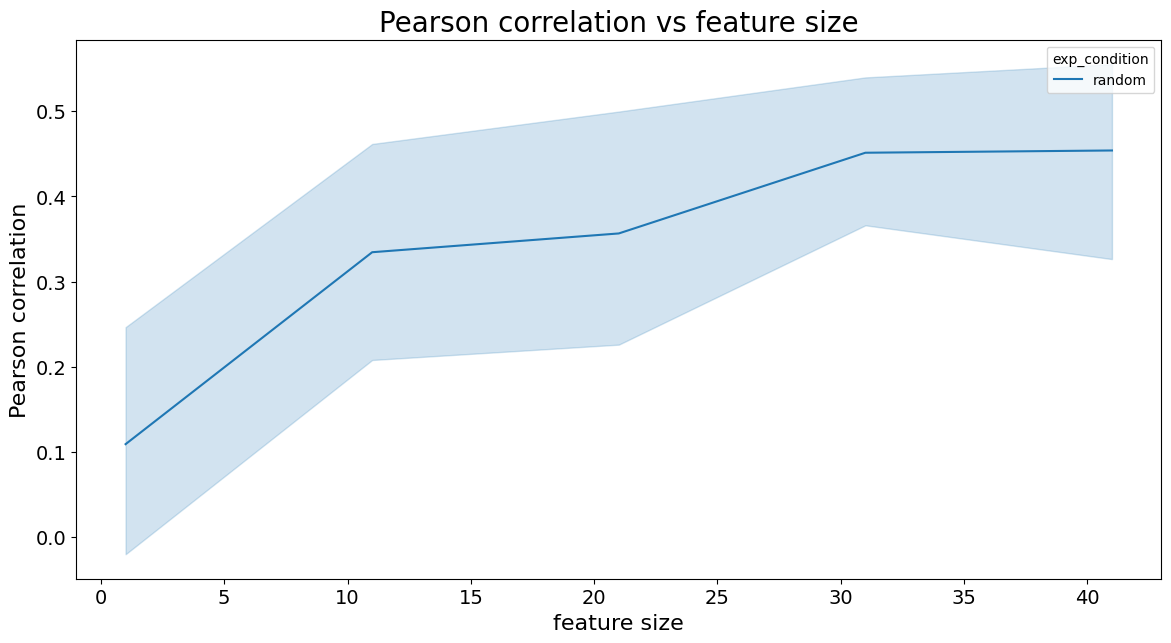

In [21]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='corr', hue='exp_condition', data=all_df, ax=ax)
ax.set_title(f'Pearson correlation vs feature size')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.savefig(save_results_path+'feature_size_pearson_corr.png', dpi=300, bbox_inches='tight')
plt.show()